In [ ]:
from   torchvision.datasets.utils import download_url
import tarfile
import torch
import os
import matplotlib.pyplot         as     plt
from   seaborn                   import scatterplot

# PER CONVERTIRE DIRECTORY DI IMMAGINI IN TENSORI
from torchvision.datasets        import ImageFolder
from torchvision.transforms      import ToTensor

# CREAZIONE DEL VALIDATION SET
from torch.utils.data            import random_split

# DATALOADER
from torch.utils.data.dataloader import DataLoader

# MOSTRARE FOTO SELEZIONATE PER BATCH
from torchvision.utils           import make_grid

# PER IMPORTARE LA CLASSE BASE
import torch.nn                  as nn

# CLASSE FUNCTIONAL PER IL CALCOLO DELLA LOSS
import torch.nn.functional       as F

Scarichiamo il dataset tramite url

In [ ]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

Using downloaded and verified file: ./cifar10.tgz


Decomprimiamo il file .tar
L'archivio contiene 2 cartelle train e test. Il training set (50000 images) e il test set (10000 images). Le classi di immagini sono 10

In [ ]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [ ]:
# MOSTRIAMO LE CLASSI PRESENTI
data_dir = './data/cifar10'

train_classes = os.listdir(os.path.join(data_dir, "train"))
test_classes  = os.listdir(os.path.join(data_dir, "test"))

print("Train classes:", train_classes)
print("Test  classes:", test_classes)

Train classes: ['horse', 'ship', 'automobile', 'bird', 'frog', 'truck', 'dog', 'airplane', 'deer', 'cat']
Test  classes: ['horse', 'ship', 'automobile', 'bird', 'frog', 'truck', 'dog', 'airplane', 'deer', 'cat']


Plottare record per classe

<ipython-input-17-f3d84fd45194>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  splt.set_xticklabels(splt.get_xticklabels(), rotation=30)


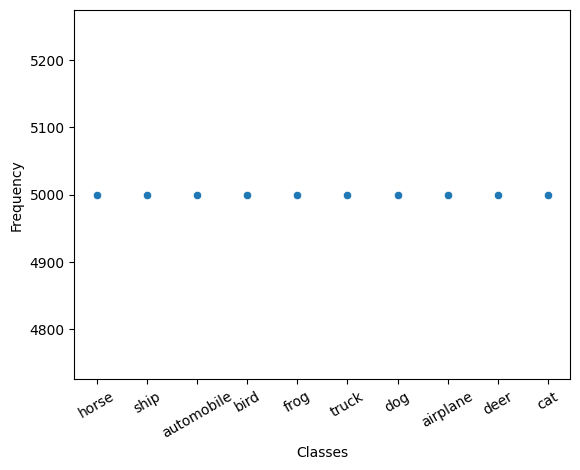

In [ ]:
train_class_freq = [
    len(os.listdir(os.path.join(data_dir, "train", sel_class)))
    for sel_class in train_classes
]

fig  = plt.plot(figsize=(10,10))
splt = scatterplot(x=train_classes, y=train_class_freq)
splt.set_xticklabels(splt.get_xticklabels(), rotation=30)
splt.set_xlabel("Classes")
splt.set_ylabel("Frequency")
plt.show()

Da directory di immagini a tensori

In [ ]:
dataset_train = ImageFolder(os.path.join(data_dir, 'train'), transform=ToTensor())

In [ ]:
# PLOTTIAMO UN PRIMO RECORD
classi       = dataset_train.classes
image, label = dataset_train[0]
print("DIMENSIONI: ", image.shape)
print("LABEL: ", label)
print("TENSORE: ", image)

DIMENSIONI:  torch.Size([3, 32, 32])
LABEL:  0
TENSORE:  tensor([[[0.7922, 0.7922, 0.8000,  ..., 0.8118, 0.8039, 0.7961],
         [0.8078, 0.8078, 0.8118,  ..., 0.8235, 0.8157, 0.8078],
         [0.8235, 0.8275, 0.8314,  ..., 0.8392, 0.8314, 0.8235],
         ...,
         [0.8549, 0.8235, 0.7608,  ..., 0.9529, 0.9569, 0.9529],
         [0.8588, 0.8510, 0.8471,  ..., 0.9451, 0.9451, 0.9451],
         [0.8510, 0.8471, 0.8510,  ..., 0.9373, 0.9373, 0.9412]],

        [[0.8000, 0.8000, 0.8078,  ..., 0.8157, 0.8078, 0.8000],
         [0.8157, 0.8157, 0.8196,  ..., 0.8275, 0.8196, 0.8118],
         [0.8314, 0.8353, 0.8392,  ..., 0.8392, 0.8353, 0.8275],
         ...,
         [0.8510, 0.8196, 0.7608,  ..., 0.9490, 0.9490, 0.9529],
         [0.8549, 0.8471, 0.8471,  ..., 0.9412, 0.9412, 0.9412],
         [0.8471, 0.8431, 0.8471,  ..., 0.9333, 0.9333, 0.9333]],

        [[0.7804, 0.7804, 0.7882,  ..., 0.7843, 0.7804, 0.7765],
         [0.7961, 0.7961, 0.8000,  ..., 0.8039, 0.7961, 0.7882],
 

Plottiamo una figura. Nota, il tensore è del tipo (3,32,32), il plotting o richiede come (32, 32, 3)

Label:  airplane (0)


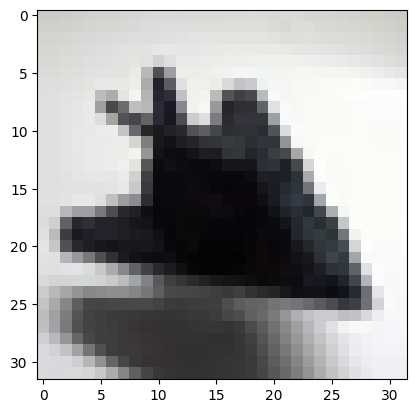

In [ ]:
print('Label: ', classi[label], "(" + str(label) + ")")
plt.imshow(image.permute(1, 2, 0))

Quando si crea un modello, è necessario avere train, test e validation set. Pertanto, creiamo un validation set dal train selezionando 10000 (20% del train)


In [ ]:
# Settiamo il seme
random_seed = 42
torch.manual_seed(random_seed);

# Train e Validation size
val_size   = 10000
train_size = len(dataset_train) - val_size

# Splitting
train_ds, val_ds = random_split(dataset_train, [train_size, val_size])

Dataloader permette di condigurare quanti dati utilizzare per ogni batch.

Dataloader permette di configurare molti parametri. Quelli di interesse:
 - dataset
 - batch_size: quanti campioni per batch caricare
 - shuffle: se True fa il data reshuffled ad ogni epoca. (default: False).
 - num_workers: quanti subprocess utilizzare per il loading
 - pin_memory: Se True, il data loader copierà i tensori all'interno del device/CUDA pinned memory prima di ritornarli.

In [ ]:
batch_size = 128
train_dl   = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl     = DataLoader(val_ds,   batch_size, num_workers=2, pin_memory=True)

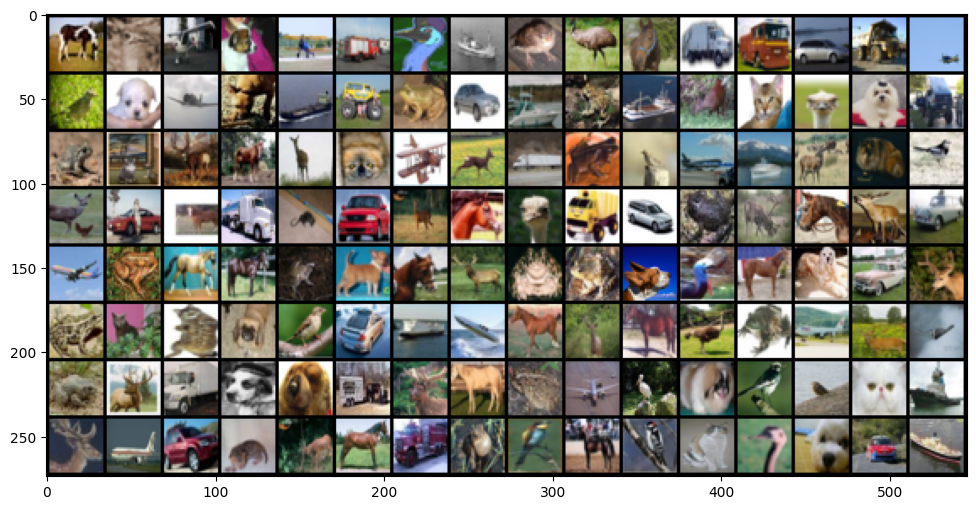

In [ ]:
# PRINTIAMO IL PRIMO BATCH
# - nrow: number of images displayed in each row of the grid.
for images, labels in train_dl:
   fig, ax = plt.subplots(figsize=(12, 6))
   ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
   break

Definiamo la classe per valutare la loss ed accuracy

In [ ]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassification(nn.Module):
  def lossComputing(self, batch):
    images, labels = batch
    labelsPred     = self(images)
    lossComputed   = F.cross_entropy(labelsPred, labels)
    return lossComputed, labelsPred

  def training_step(self, batch):
    return self.lossComputing(batch)[0]

  def validation_step(self, batch):
    loss, labelsPred = self.lossComputing(batch)
    accur            = accuracy(labelsPred, batch[1])
    # detach(): Returns a new Tensor, detached from the current graph.
    return {'val_loss': loss.detach(), 'val_acc': accur}

  def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss   = torch.stack(batch_losses).mean()    # Combine losses
        batch_accs   = [x['val_acc'] for x in outputs]
        epoch_acc    = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

Modello

In [ ]:
class Cifar10CnnModel(ImageClassification):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10))

    def forward(self, xb):
        return self.network(xb)

model = Cifar10CnnModel()

Configuriamo il device e funzione per muovere dati sulla GPU

In [ ]:
def to_device(data, device):
    """Sposta i tensori sul device selezionato"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Dataloader per caricare i dati sul device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Sposta il batch sul device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Numero di batch"""
        return len(self.dl)


device   = torch.device('cuda')
train_dl = DeviceDataLoader(train_dl, device)
val_dl   = DeviceDataLoader(val_dl, device)
model    = to_device(model, device);

Fase di training

In [ ]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# SGD: stochastic gradient descent
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            # Calcola il gradiente del tensore attuale.
            loss.backward()
            # Lancia la fase di ottimizzazione per aggiornare i parametri.
            optimizer.step()
            # Resetta il gradiente di tutti i Tensori ottimizzati.
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


MAIN

In [ ]:
num_epochs = 10
opt_func   = torch.optim.Adam
lr         = 0.001

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 2.0565, val_loss: 1.7458, val_acc: 0.3250
Epoch [1], train_loss: 1.5453, val_loss: 1.3733, val_acc: 0.4805
Epoch [2], train_loss: 1.2214, val_loss: 1.0982, val_acc: 0.5965
Epoch [3], train_loss: 1.0210, val_loss: 0.9820, val_acc: 0.6512
Epoch [4], train_loss: 0.8770, val_loss: 0.8835, val_acc: 0.6944
Epoch [5], train_loss: 0.7737, val_loss: 0.9000, val_acc: 0.6852
Epoch [6], train_loss: 0.6840, val_loss: 0.8419, val_acc: 0.7176
Epoch [7], train_loss: 0.6120, val_loss: 0.8040, val_acc: 0.7325
Epoch [8], train_loss: 0.5262, val_loss: 0.7992, val_acc: 0.7347
Epoch [9], train_loss: 0.4628, val_loss: 0.8081, val_acc: 0.7483


Plotting

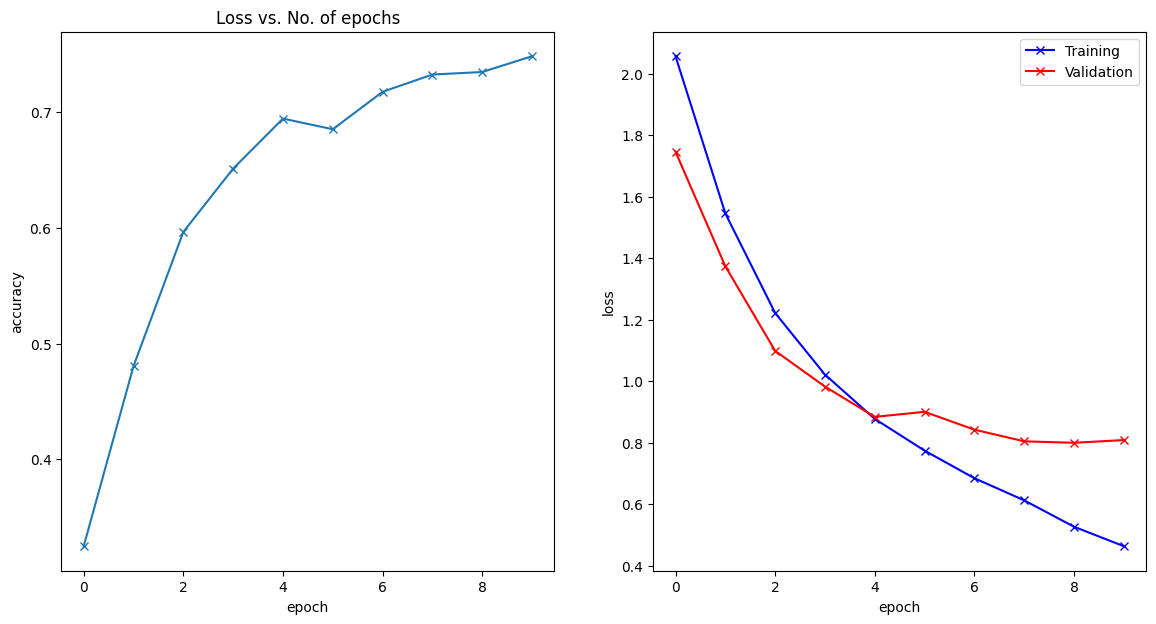

In [ ]:
# ACCURACY ANF LOSS PLOT
subplots, axis = plt.subplots(1,2, figsize=(14,7))
# Accuracy
accuracies = [x['val_acc'] for x in history]
axis[0].plot(accuracies, '-x')
axis[0].set_xlabel('epoch')
axis[0].set_ylabel('accuracy')
axis[0].set_title('Accuracy vs. No. of epochs');
# Loss
train_losses = [x.get('train_loss') for x in history]
val_losses   = [x['val_loss'] for x in history]
axis[1].plot(train_losses, '-bx')
axis[1].plot(val_losses, '-rx')
axis[1].set_xlabel('epoch')
axis[1].set_ylabel('loss')
axis[1].legend(['Training', 'Validation'])
axis[0].set_title('Loss vs. No. of epochs');
plt.show()

Predictiom

In [ ]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

img, label   = test_dataset[0]
# Crea batch di dimensione 1
xb = to_device(img.unsqueeze(0), device)
yb = model(xb)
_, preds  = torch.max(yb, dim=1)
print('Label:', dataset_train.classes[label], ', Predicted:', dataset_train.classes[preds.item()])

Label: airplane , Predicted: airplane


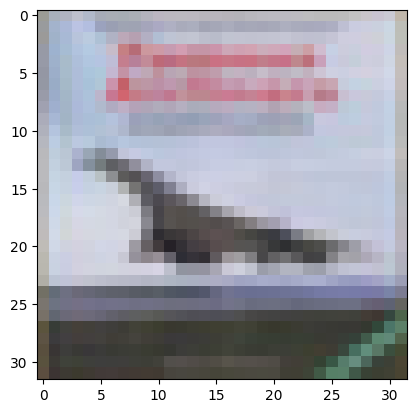

In [ ]:
plt.imshow(img.permute(1, 2, 0))